In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

import cv2
from src.utils.func import (crop_center, read_image_as_numpyimage, 
    pipette_color, apply_pht, _convert_hough_segments_to_lines,
    group_lines)
from src.utils.playfield_finder import PlayfieldFinder
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'

In [2]:
pic = read_image_as_numpyimage('/home/polymorvic/development/deep-peep-snooker/pics/pic_07_34_02.png', 'rgb') # pic_02_07_01.png   pic_05_18_01.png # runda_8/pic_08_08_01.png'
cropped_pic = crop_center(pic)

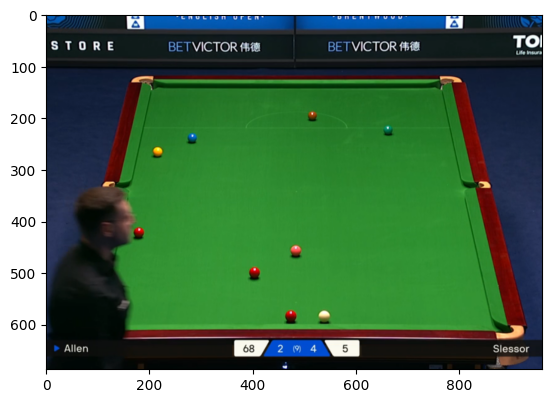

In [3]:
plt.imshow(pic)

In [4]:
finder = PlayfieldFinder(pic)

In [5]:
cushions = finder.find_side_cushions()

AttributeError: 'PlayfieldFinder' object has no attribute 'find_side_cushions'

In [ ]:
# img = cushions['top_left'][0]

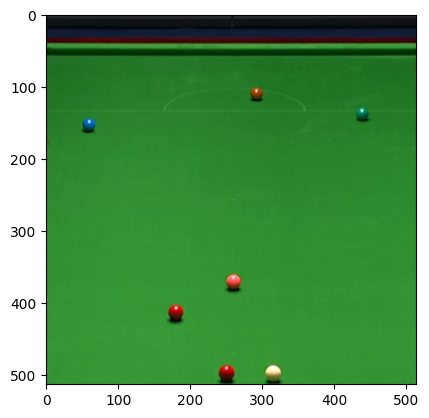

In [5]:
plt.imshow(cropped_pic)

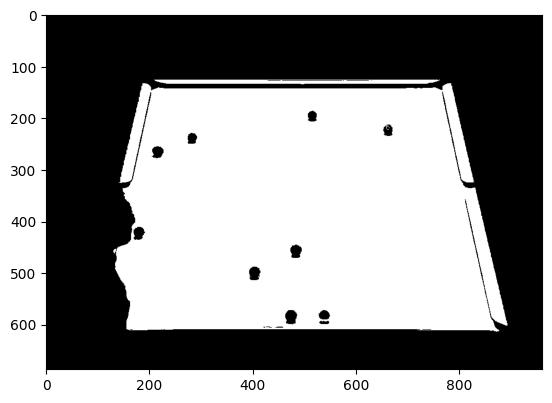

In [6]:
pic_hsv = cv2.cvtColor(pic, cv2.COLOR_RGB2HSV)
cropped_pic_hsv = cv2.cvtColor(cropped_pic, cv2.COLOR_RGB2HSV)

dominant_color = pipette_color(cropped_pic_hsv)

h, s, v = dominant_color
h_std = np.std(cropped_pic_hsv[:, :, 0])
s_std = np.std(cropped_pic_hsv[:, :, 1])
v_std = np.std(cropped_pic_hsv[:, :, 2])

h_tolerance = int(h_std * 1.5)
s_tolerance = int(s_std * 1.5)
v_tolerance = int(v_std * 1.5)

lower_bound = np.array([max(0, h - h_tolerance), 
                       max(0, s - s_tolerance), 
                       max(0, v - v_tolerance)])

upper_bound = np.array([min(179, h + h_tolerance), 
                       min(255, s + s_tolerance), 
                       min(255, v + v_tolerance)])

binary_mask = cv2.inRange(pic_hsv, lower_bound, upper_bound)

plt.imshow(binary_mask)
plt.show()

In [7]:
inv_binary_img = cv2.bitwise_not(binary_mask)

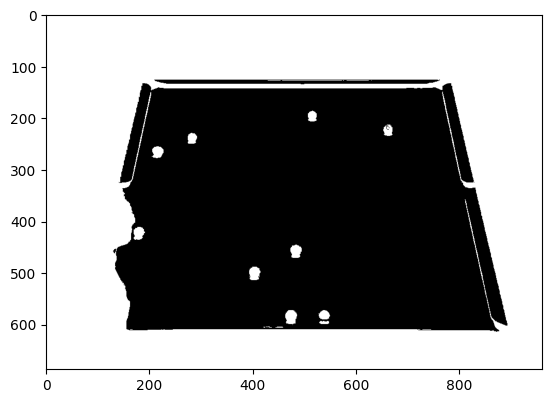

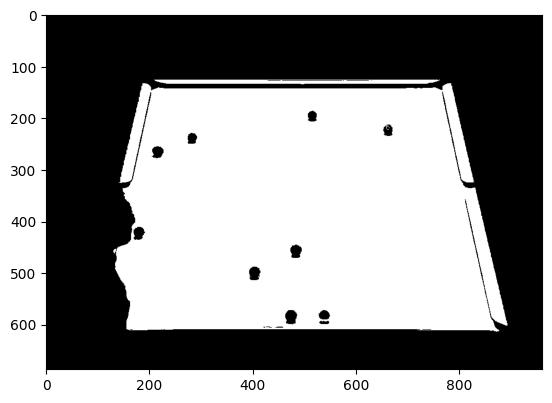

In [8]:
plt.imshow(inv_binary_img)
plt.show()
plt.imshow(binary_mask)

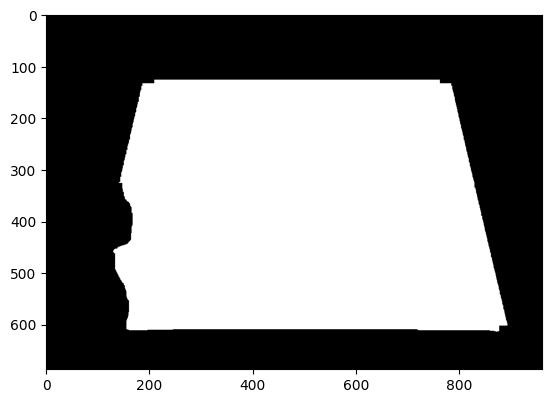

In [9]:
binary_mask_close = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((21, 21), np.uint8))
plt.imshow(binary_mask_close)

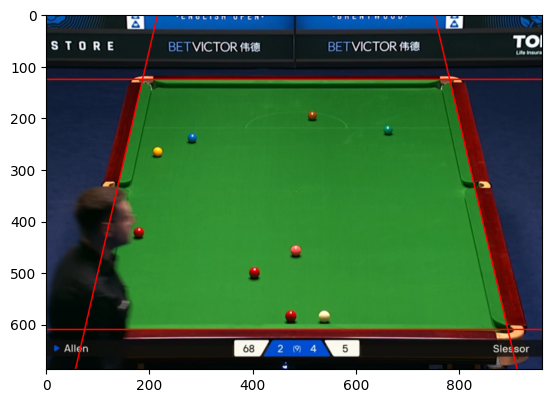

In [10]:
edges = cv2.Canny(binary_mask_close, 150, 200)

segments = cv2.HoughLinesP(
    edges, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)
lines = group_lines(lines, thresh_theta=5, thresh_intercept=100)

pic_copy = pic.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 2)

plt.imshow(pic_copy)

In [17]:
intersections = set()
for group1 in lines:
    for group2 in lines:
        intersection = group1.intersection(group2, pic_copy)
        if intersection is not None:
            intersections.add(intersection)
            
intersections = list(intersections)

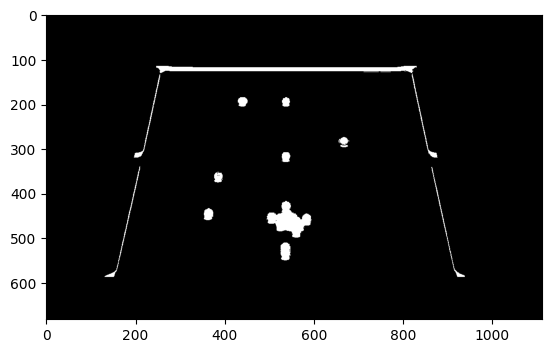

In [18]:
intersection_points = np.array([[int(inter.point.x), int(inter.point.y)] for inter in intersections])
hull = cv2.convexHull(intersection_points)

height, width = inv_binary_img.shape
mask = np.zeros((height, width), dtype=np.uint8)

cv2.fillPoly(mask, [hull], 255)

# Create a thicker outline around the lines to black out pixels on the other side
# We need to use lines from cell 10 which created the mask
line_buffer_distance = 5  # Distance in pixels to black out on other side of lines

# Draw thick lines on mask to black out the other side
for line in lines:
    pts = line.limit_to_img(mask)
    if pts:
        pt1, pt2 = pts
        # Draw a thick black line to create a buffer zone
        cv2.line(mask, (int(pt1.x), int(pt1.y)), (int(pt2.x), int(pt2.y)), 0, line_buffer_distance * 2)

masked_img = cv2.bitwise_and(inv_binary_img, mask)
plt.imshow(masked_img)


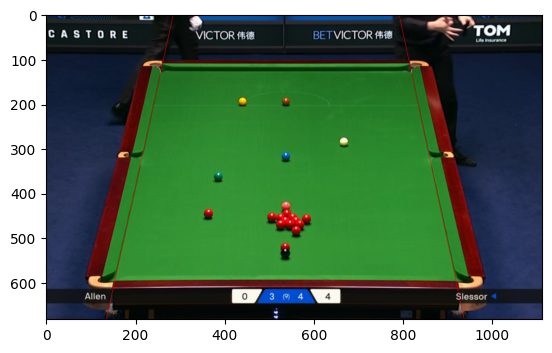

In [19]:
segments = cv2.HoughLinesP(
    masked_img, 
    1, 
    np.pi / 180, 
    threshold=100, 
    minLineLength=100, 
    maxLineGap=10
)

lines = _convert_hough_segments_to_lines(segments)

# # Create pairs of segment and line
# segment_line_pairs = []
# if segments is not None:
#     for i, segment in enumerate(segments):
#         segment_line_pairs.append({
#             'segment': segment[0],  # (x1, y1, x2, y2)
#             'line': lines[i]
#         })

lines = [line for line in lines if line.slope is None or abs(line.slope) >= 0.1]
lines = group_lines(lines, thresh_theta=50, thresh_intercept=200)

# segment_line_pairs = [pair for pair in segment_line_pairs if pair['line'].slope is None or abs(pair['line'].slope) >= 0.1]

if len(lines) != 2:
    positive = [lg for lg in lines if lg.slope is not None and lg.slope > 0]
    negative = [lg for lg in lines if lg.slope is not None and lg.slope < 0]
    
    if positive and negative:
        lines = [max(positive, key=lambda lg: len(lg.lines)), 
                    max(negative, key=lambda lg: len(lg.lines))]
    else:
        pass


pic_copy = pic.copy()
for line in lines:
    pts = line.limit_to_img(pic_copy)
    cv2.line(pic_copy, *pts, (255, 0, 0), 1)


plt.imshow(pic_copy)

In [20]:
lines


[LineGroup: y = 4.65 * x + -3684.61 (from 2 lines),
 LineGroup: y = -4.52 * x + 1293.46 (from 4 lines)]